<a href="https://colab.research.google.com/github/ankitgoelcmu/DeepLearning/blob/main/VIT_paper_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
  Using cached torch-2.9.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.24.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached torchaudio-2.9.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached https://download.pytorch.org/whl/nightly/nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x8

In [52]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 14.69 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [54]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [55]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [56]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [57]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a12ee9d71d0>,
 ['pizza', 'steak', 'sushi'])

In [58]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

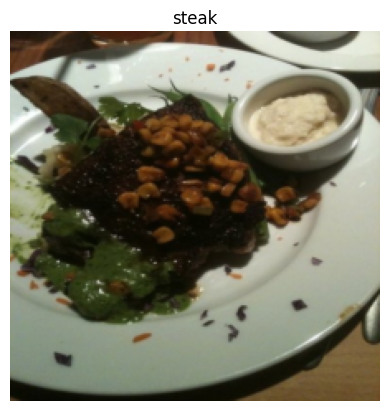

In [59]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [11]:
# TODO: Ankit
class ViT (nn.Module):
  def __init__ (self,
                img_size: int=224,
                patch_size: int=16,
                in_channels: int=3,
                num_classes: int=1000,
                mlp_size: int=3072,
                num_heads: int=12,
                num_encooder_layer: int=12,
                embedding_dim: int=768,
                attn_dropout: float=0,
                mlp_dropput: float=0.1,
                embedding_dropout: float=0.1,
                num_out_class: int=1000):
    super().__init__()

    assert img_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
    self.num_patches = int((img_size // patch_size) ** 2)
    self.patch_size = patch_size

    self.embedding_class = nn.Parameter(torch.zeros(1, 1, embedding_dim))
    self.embedding_position = nn.Parameter(torch.zeros(1, 1 + self.num_patches, embedding_dim))
    self.embedding_dropout = nn.Dropout(embedding_dropout)
    self.patch = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size)
    self.flatten_patches = nn.Flatten (start_dim=2, end_dim=3)
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                    nhead=num_heads,
                                                    dim_feedforward=mlp_size,
                                                    dropout=attn_dropout,
                                                    activation='gelu',
                                                    batch_first=True,
                                                    norm_first=True)  #batch, seq, feature. --> image batch, patch seq, embidding features
    self.encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layer,
                                         num_layers=num_encooder_layer)

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim, out_features=num_out_class)
                                    )



  def forward(self, x):
    batch_size = x.shape[0]
    x = self.patch (x)
    x = self.flatten_patches(x)
    x = x.permute(0, 2, 1)
    class_embedding = self.embedding_class.expand(batch_size, -1, -1)
    x = torch.cat([class_embedding, x], dim=1)
    x = self.embedding_position + x
    x = self.embedding_dropout(x)
    x = self.encoder(x)
    x = self.classifier(x[:, 0])
    return x






In [12]:
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)
vit = ViT(num_out_class=3)
vit(random_image_tensor)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


tensor([[ 1.8354,  0.5861, -0.3603]], grad_fn=<AddmmBackward0>)

In [13]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              7,239,936            True
├─Conv2d (patch)                                        [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Flatten (flatten_patches)                             [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (encoder)                          [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)                 [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │ 

In [ ]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)
embedding_class = nn.Parameter(torch.zeros(1, 1, 768))
embedding_class.shape
patch_features_oo = nn.Conv2d(in_channels=3,
                                    out_channels=768,
                                    kernel_size=16,
                                    stride=16)


In [14]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5203 | train_acc: 0.4023 | test_loss: 2.1343 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.8195 | train_acc: 0.2773 | test_loss: 1.4326 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2866 | train_acc: 0.4023 | test_loss: 1.6517 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.3014 | train_acc: 0.4336 | test_loss: 1.2225 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.4423 | train_acc: 0.3047 | test_loss: 1.2062 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.4469 | train_acc: 0.2930 | test_loss: 1.0120 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.2016 | train_acc: 0.4180 | test_loss: 1.3648 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1283 | train_acc: 0.4531 | test_loss: 1.2685 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.2127 | train_acc: 0.3984 | test_loss: 1.0036 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.1368 | train_acc: 0.4062 | test_loss: 1.3633 | test_acc: 0.2604


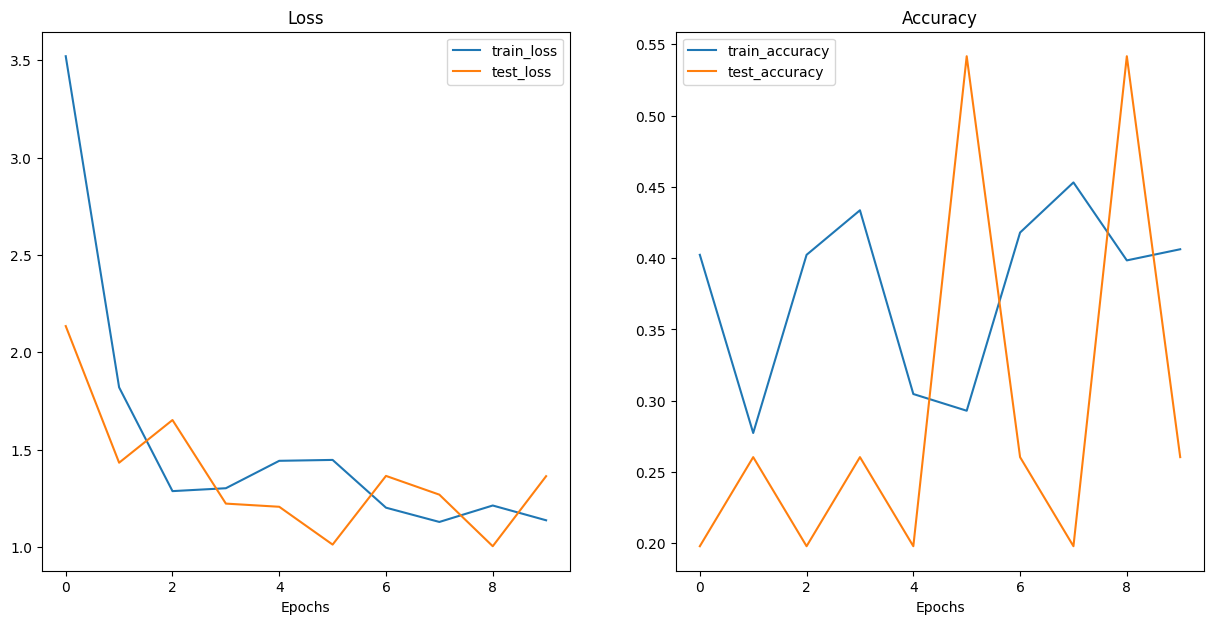

In [15]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### So far we have used Pytorch OOB Layer `TransformerEncoderLayer` to implement Encoder layer of the ViT transformer.
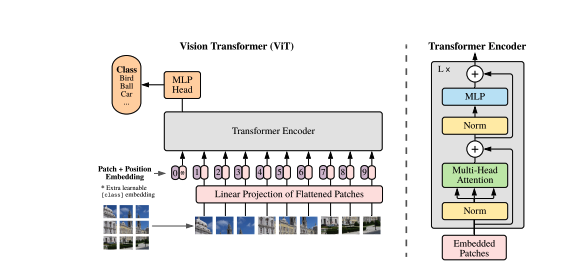

# In this step we will implement Encode Layer with Multi Head Block and MLP Block.

### `Multi Head Block `= `Layer Norm(Embedded Patches) --> Multi Head Attention + Embedded Patches (Residual Connection) + Dropout `

#### **Residual Connection** - Residual connections help stabilize neural network training by providing a direct pathway for information and gradient flow during the forward pass and backpropagation.

In [19]:
from torch import nn

# Implementation of MHA block
class MultiHeadAttention(nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,

               dropout: float=0.1): #assuming no dropout in MHA block as ViT paper doesn't mention it
      super().__init__()

      #Calculate number of patches (height * width/patch^2)
      self.embedding_dim = embedding_dim
      self.num_heads = num_heads

      #Normalization layer - Layer Normalization normalizes activations across feature dimensions within a layer,
      #ensuring that no single feature’s scale dominates the others, which stabilizes training and improves gradient flow.
      self.norm = nn.LayerNorm(embedding_dim)
      self.MultiHeadAttention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                      num_heads=num_heads,
                                                      dropout=dropout,
                                                      batch_first=True) #If True, then the input and output tensors are provided as (batch, seq, feature) --> batch_size, embdded_patch_feature, embedded_feature_dimension
      self.dropout = nn.Dropout(dropout)


  def forward(self, x):
    residual_input = x
    x = self.norm(x)
    x, attn_output_weights = self.MultiHeadAttention(x, x, x)
    x = self.dropout(x)
    return x + residual_input

In [24]:
import torch
from torch import nn

patched_position_embedded_tensor = torch.randn(1, 197, 768) # (batch_size, patch_seq_length, embedding_dim)

MHA_instance = MultiHeadAttention()
output_after_MHA_block = MHA_instance(patched_position_embedded_tensor)
print(f"Input shape of MHA block: {patched_position_embedded_tensor.shape}")
print(f"Output shape MHA block: {output_after_MHA_block.shape}")

Input shape of MHA block: torch.Size([1, 197, 768])
Output shape MHA block: torch.Size([1, 197, 768])


# In this step we will implement MLP Block. Paper Quote: "The MLP contains two layers with a GELU non-linearity in between." Dropout is implied/standard (0.1 rate, as in the full transformer spec).
##` MLP = Layer Norm Linear -> Linear (expand) → GELU activation → Dropout → Linear (contract) → Dropout + Output from Multi Head Block (residual connection)`

In [23]:
from torch import nn

# Implementation of MLP block

class MLP (nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               dropout: float=0.1,
               mlp_size: int=3072):
      super().__init__()
      #Normalization layer - Layer Normalization normalizes activations across feature dimensions within a layer,
      #ensuring that no single feature’s scale dominates the others, which stabilizes training and improves gradient flow.
      self.norm = nn.LayerNorm(embedding_dim)
      self.mlp_layer = nn.Sequential(nn.Linear(embedding_dim, mlp_size),
                                     nn.GELU(),
                                     nn.Dropout(dropout),
                                     nn.Linear(mlp_size, embedding_dim))
      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    residual_input = x
    x = self.norm(x)
    x = self.mlp_layer(x)
    x = self.dropout(x)
    return x + residual_input


In [27]:
##Testing

import torch
from torch import nn

output_after_MHA_block = torch.randn(1, 197, 768) # (batch_size, patch_seq_length, embedding_dim)

MLP_instance = MLP()
output_after_MLP_block = MHA_instance(output_after_MHA_block)
print(f"Input shape of MLP block: {output_after_MHA_block.shape}")
print(f"Output shape MLPblock: {output_after_MLP_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLPblock: torch.Size([1, 197, 768])


## In this step we will create Encoder Layer combinind our above two blocks `MultiHeadAttention` and `MLP`

In [41]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size: int=3072,
                 dropout: float=0.1):
        super().__init__()
        self.mha_block = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.mlp_block = MLP(embedding_dim, dropout,mlp_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Sequential: Attention then MLP
        x = self.mha_block(x)
        x = self.mlp_block(x)
        return x

In [34]:
##Testing

import torch
from torch import nn

patched_position_embedded_tensor = torch.randn(1, 197, 768) # (batch_size, patch_seq_length, embedding_dim)

encoder = EncoderLayer()
output_after_encoder_layer  = encoder(patched_position_embedded_tensor)
print(f"Input shape to Encoder Layer: {patched_position_embedded_tensor.shape}")
print(f"Output shape after Encoder Layer: {output_after_encoder_layer.shape}")

Input shape to Encoder Layer: torch.Size([1, 197, 768])
Output shape after Encoder Layer: torch.Size([1, 197, 768])


# Now Lets re-implement Vit with our custom made Encoder Layer

In [44]:
# TODO: Ankit
class ViT_01 (nn.Module):
  def __init__ (self,
                img_size: int=224,
                patch_size: int=16,
                in_channels: int=3,
                mlp_size: int=3072,
                num_heads: int=12,
                num_encooder_layers: int=12,
                embedding_dim: int=768,
                attn_dropout: float=0.1,
                mlp_dropout: float=0.1,
                embedding_dropout: float=0.1,
                num_out_class: int=1000):
    super().__init__()

    assert img_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
    self.num_patches = int((img_size // patch_size) ** 2)
    self.patch_size = patch_size

    self.embedding_class = nn.Parameter(torch.zeros(1, 1, embedding_dim))
    self.embedding_position = nn.Parameter(torch.zeros(1, 1 + self.num_patches, embedding_dim))
    self.embedding_dropout = nn.Dropout(embedding_dropout)
    self.patch = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size)
    self.flatten_patches = nn.Flatten(start_dim=2, end_dim=3)

    # Custom encoder stack (ModuleList for explicit layering)
    self.encoder_layers = nn.ModuleList([
            EncoderLayer(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size
            )
            for _ in range(num_encooder_layers)
        ])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim, out_features=num_out_class)
                                    )



  def forward(self, x):
    batch_size = x.shape[0]
    x = self.patch(x)
    x = self.flatten_patches(x)
    x = x.permute(0, 2, 1)
    class_embedding = self.embedding_class.expand(batch_size, -1, -1)
    x = torch.cat([class_embedding, x], dim=1)
    x = self.embedding_position + x
    x = self.embedding_dropout(x)
    # Encoder stack (FIX: Loop over layers)
    for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
    x = self.classifier(x[:, 0])
    return x






In [45]:
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)
vit = ViT_01(num_out_class=3)
vit(random_image_tensor)

tensor([[-0.0074,  0.4755, -1.0295]], grad_fn=<AddmmBackward0>)

In [60]:
# Try to get torchinfo, install it if it doesn't work
!pip install -q torchinfo
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT_01 (ViT_01)                                              [32, 3, 224, 224]    [32, 3]              152,064              True
├─Conv2d (patch)                                             [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Flatten (flatten_patches)                                  [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─ModuleList (encoder_layers)                                --                   --                   --                   True
│    └─EncoderLayer (0)                                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MultiHeadAttention (mha_block)                   [32, 197, 768]       [32, 197, 768]

In [61]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.4834 | train_acc: 0.2773 | test_loss: 1.6347 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.8821 | train_acc: 0.2969 | test_loss: 1.7710 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.2163 | train_acc: 0.3594 | test_loss: 1.2536 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2795 | train_acc: 0.2891 | test_loss: 1.2497 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1597 | train_acc: 0.2578 | test_loss: 1.0394 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.2010 | train_acc: 0.4062 | test_loss: 1.2575 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2188 | train_acc: 0.2734 | test_loss: 1.2789 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1744 | train_acc: 0.2617 | test_loss: 1.1095 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1637 | train_acc: 0.2930 | test_loss: 1.1212 | test_acc: 0.2083
Epoch: 10 | train_loss: 1.1181 | train_acc: 0.4102 | test_loss: 1.0214 | test_acc: 0.5417


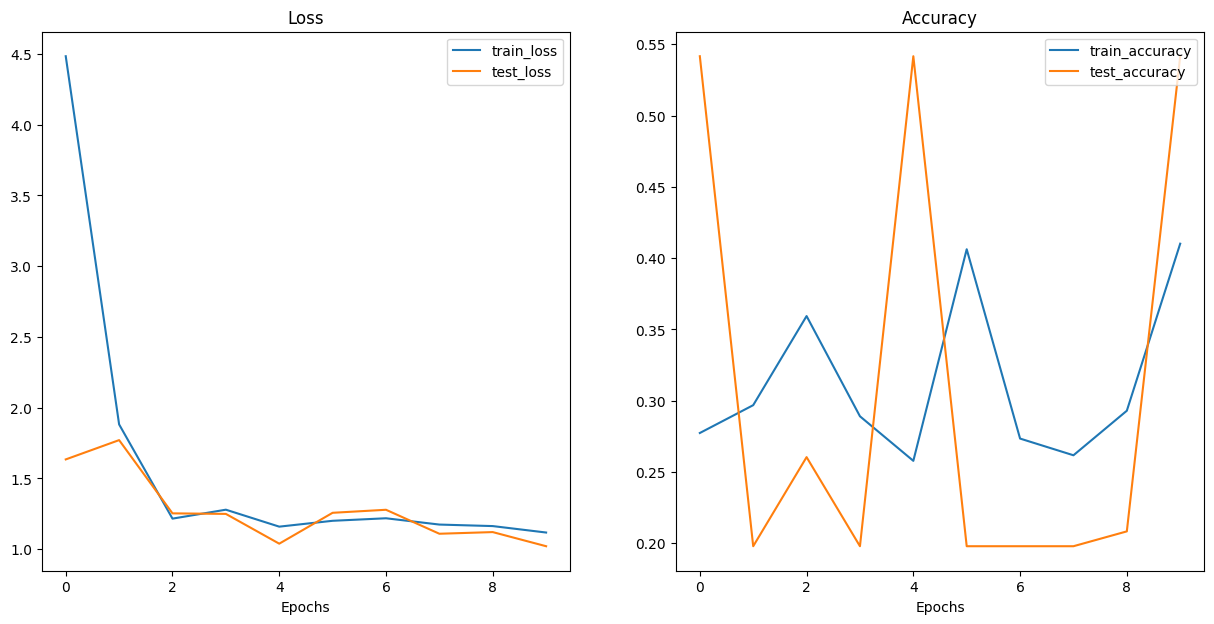

In [62]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)